In [57]:
import torch
from torchvision import datasets, transforms
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

In [58]:
# constants
BATCH_SIZE = 2048
target_mean = 0.5 # for normalizing image data
target_std = 0.5 # for normalizing image data

## Load data

In [59]:
initial_transform = transforms.Compose([transforms.ToTensor(),])
initial_dataset = datasets.MNIST(root='./data', train=True, transform=initial_transform, download=True)
initial_loader = torch.utils.data.DataLoader(initial_dataset, batch_size=len(initial_dataset))

In [60]:
data = next(iter(initial_loader))[0] # gets the entire dataset
current_mean = data.mean().item()
current_std = data.std().item()

In [61]:
print(f"{data.shape = }")
print(f"{current_mean = }")
print(f"{current_std = }")

data.shape = torch.Size([60000, 1, 28, 28])
current_mean = 0.13066047430038452
current_std = 0.30810782313346863


In [62]:
transform_mean = (current_mean * target_std - target_mean * current_std) / target_std
transform_std = current_std / target_std

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((transform_mean,), (transform_std,)),
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [63]:
# test statistics (make sure mean and median are 0.5 and 0.5)
statistics_test_loader = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
statistics_test_loader = torch.utils.data.DataLoader(statistics_test_loader, batch_size=len(statistics_test_loader))
data = next(iter(statistics_test_loader))[0] # gets the normalized entire dataset
current_mean = data.mean().item()
current_std = data.std().item()
print(f"{data.shape = }")
print(f"{current_mean = }") # confirm mean ~0.5
print(f"{current_std = }")  # confirm std  ~0.5

data.shape = torch.Size([60000, 1, 28, 28])
current_mean = 0.4999999701976776
current_std = 0.4999999701976776


## Training

In [64]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [65]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 2048),
            nn.ReLU(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 512),
            nn.ReLU(),
            nn.Linear(512, 2048),
            nn.ReLU(),
            nn.Linear(in_features=2048, out_features=28*28, bias=False),
        )

    def forward(self, x):
        encoding = self.encoder(x)
        # TODO: masking
        logits = self.decoder(encoding)
        return encoding, logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2048, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2048, out_features=784, bias=False)
  )
)


In [66]:
l1_loss = nn.L1Loss()
def loss_fn(X, X_hat, encoding, lambda_term=0.003):
    # Mean absolute error for reconstruction
    mae_reconstruction = l1_loss(X, X_hat)
    # L1 norm for encoding
    encoding_loss = torch.norm(encoding, p=1) * lambda_term * (1/BATCH_SIZE)
    return mae_reconstruction + encoding_loss

In [67]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [68]:
def train(data_loader, loss, optimizer, model, epochs=1):
    model.train()
    train_loss_statistics = []
    
    for epoch in range(epochs):
        for batch_idx, data in enumerate(data_loader):
            X, y = data
            X = torch.flatten(X, start_dim=1).to(device)
            encoding, X_hat = model.forward(X)

            batch_loss = loss(X, X_hat, encoding)
            batch_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss_statistics.append(batch_loss.item())

            if batch_idx % 10 == 0:
                print(f"batch #{len(data_loader)*epoch + batch_idx}: {batch_loss}")
                
    return train_loss_statistics

In [69]:
train_loss_statistics = train(train_loader, loss_fn, optimizer, model, epochs=200)

batch #0: 0.5033351182937622
batch #10: 0.2800479233264923
batch #20: 0.2150609940290451
batch #30: 0.21421018242835999
batch #40: 0.20693941414356232
batch #50: 0.20713751018047333
batch #60: 0.2039511352777481
batch #70: 0.2014823853969574
batch #80: 0.20758667588233948
batch #90: 0.20536218583583832
batch #100: 0.20382611453533173
batch #110: 0.20567797124385834
batch #120: 0.20387589931488037
batch #130: 0.2047785371541977
batch #140: 0.20531997084617615
batch #150: 0.20508185029029846
batch #160: 0.20324312150478363
batch #170: 0.20248253643512726
batch #180: 0.19864273071289062
batch #190: 0.19707918167114258
batch #200: 0.1937934011220932
batch #210: 0.19359415769577026
batch #220: 0.19285504519939423
batch #230: 0.19338014721870422
batch #240: 0.19224214553833008
batch #250: 0.1927487552165985
batch #260: 0.19200678169727325
batch #270: 0.19375765323638916
batch #280: 0.1910708248615265
batch #290: 0.1942131519317627
batch #300: 0.1904182881116867
batch #310: 0.1917289346456527

batch #2540: 0.0865938737988472
batch #2550: 0.08822692930698395
batch #2560: 0.08695123344659805
batch #2570: 0.08548526465892792
batch #2580: 0.0844033807516098
batch #2590: 0.08508084714412689
batch #2600: 0.08654894679784775
batch #2610: 0.08617980778217316
batch #2620: 0.08529797941446304
batch #2630: 0.08591598272323608
batch #2640: 0.08473087847232819
batch #2650: 0.08386630564928055
batch #2660: 0.08546704053878784
batch #2670: 0.08359896391630173
batch #2680: 0.0847322940826416
batch #2690: 0.08494527637958527
batch #2700: 0.08664516359567642
batch #2710: 0.08614611625671387
batch #2720: 0.08376642316579819
batch #2730: 0.08305630087852478
batch #2740: 0.08647794276475906
batch #2750: 0.08451582491397858
batch #2760: 0.0835225060582161
batch #2770: 0.08429984748363495
batch #2780: 0.08290491998195648
batch #2790: 0.08323577046394348
batch #2800: 0.08316780626773834
batch #2810: 0.08316640555858612
batch #2820: 0.08317872881889343
batch #2830: 0.08339396864175797
batch #2840: 0

batch #5040: 0.06770869344472885
batch #5050: 0.06682228296995163
batch #5060: 0.06714306771755219
batch #5070: 0.06690213084220886
batch #5080: 0.06844917684793472
batch #5090: 0.06621266156435013
batch #5100: 0.06748885661363602
batch #5110: 0.06541157513856888
batch #5120: 0.0669187381863594
batch #5130: 0.06619014590978622
batch #5140: 0.06737225502729416
batch #5150: 0.06749068200588226
batch #5160: 0.0676959753036499
batch #5170: 0.06672707200050354
batch #5180: 0.06665925681591034
batch #5190: 0.06631705164909363
batch #5200: 0.06596297770738602
batch #5210: 0.06655657291412354
batch #5220: 0.0661710575222969
batch #5230: 0.06644365936517715
batch #5240: 0.06508268415927887
batch #5250: 0.06607434898614883
batch #5260: 0.06717788428068161
batch #5270: 0.0671105608344078
batch #5280: 0.06629820913076401
batch #5290: 0.06642083078622818
batch #5300: 0.06728260219097137
batch #5310: 0.06656119972467422
batch #5320: 0.06720490008592606
batch #5330: 0.06552081555128098
batch #5340: 0

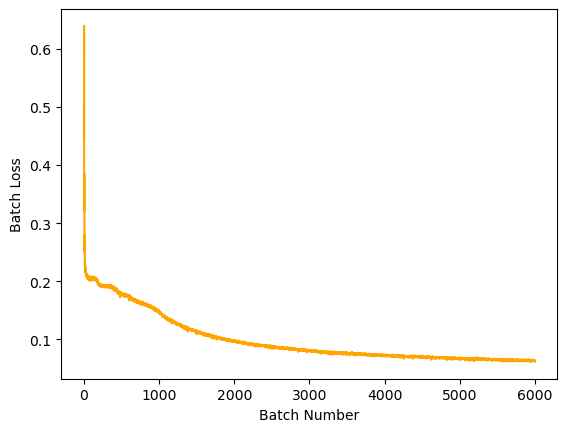

In [70]:
plt.plot(np.arange(0, len(train_loss_statistics)), train_loss_statistics, color='orange')
plt.xlabel("Batch Number")
plt.ylabel("Batch Loss")
plt.show()

## Saving Model

In [89]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': 200,
    'loss': 0.06390269100666046
}, "200_epochs_no_correlation_loss/model.pth")

## Generating Image Samples

In [81]:
test_images_batch = next(iter(test_loader))[0]

In [82]:
# get reconstructed images
_encodings, reconstructed_test_imgs = model.forward(torch.flatten(test_images_batch, start_dim=1).to("mps"))
reconstructed_test_imgs = reconstructed_test_imgs.view(-1, 28, 28)
reconstructed_test_imgs= reconstructed_test_imgs.cpu().detach()

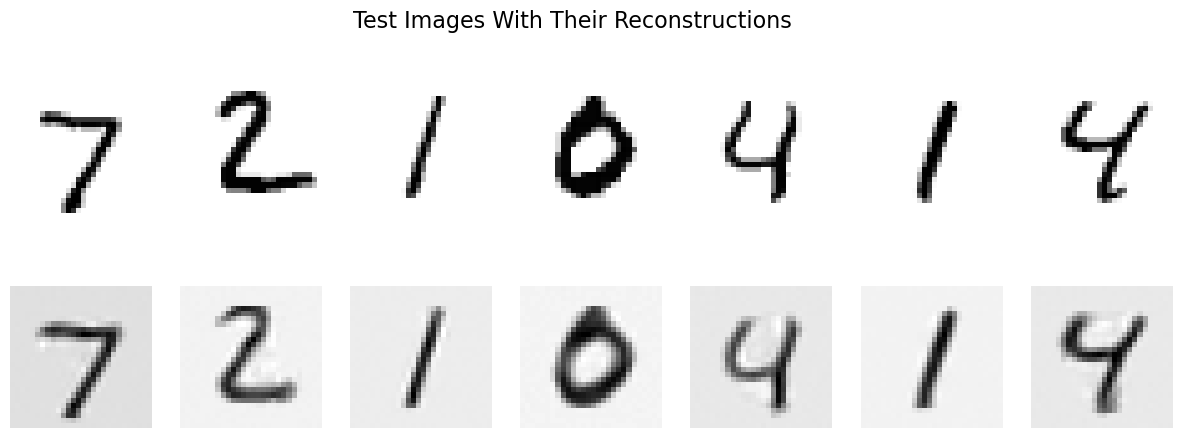

In [88]:
columns = 7
rows = 2
fig, axes = plt.subplots(rows, columns, figsize=(15, 5))
for i, ax in enumerate(axes.flat):
    if i >= columns:
        ax.imshow(reconstructed_test_imgs[i - columns]* -1, cmap='gray')
    else:
        ax.imshow(test_images_batch[i].squeeze()* -1, cmap='gray')
    ax.axis('off')
fig.suptitle('Test Images With Their Reconstructions', fontsize=16)
plt.show()
plt.savefig('image_reconstruct.png', dpi=300)